In [1]:
import pandas as pd
import requests
import json
import matplotlib.pyplot as plt

## ДЗ работа с API

Как максимум я хочу, чтобы вы собрали большую таблицу по вакансиям и проанализировали её. При этом выберите ту должность, которая интересно лично вам.

Предлагаю такие шаги:

1. Какие данные из вакансии заслуживают внимания? Что стоит доставать и помещать в таблицу? Уделите особое внимание численным параметрам - с остальными мы пока не особо учились работать.
2. Какие данные могут быть проблемными? Где-то могут встречаться пропуски, как в зарплатах, их нужно обработать.
3. Как собрать больше вакансий? Больше 100 на странице не получится, а страниц может быть несколько. Надо собрать данные со всех.
4. Какой базовый анализ можно провести? Интересно, какие зарплаты предлагают по должностям, в каких городах сколько вакансий, и прочее, прочее, прочее...

Уверен, это не составит большого труда, у вас всё получится!

1) Список необходимых столбцов для добавления в таблицу, указаны в пункте формирования датафрейма. Численных параметров оказалось не так много.
2) АПИ в целом заставляет проводить проверку каждого параметра на нахождение его в возвращаемом словаре, так как в случае пропуска можем поймать ошибку. При попытке перевести значения зарплаты перевести в целочисленное значение возникла ошибка. Оказалось `None` наследуется только от `float`, поэтому перевел значения в данный тип.
3) Больше вакансий собирал через цикл, времени занимает немного даже для 2000 вакансий, в коде приведены результаты замеров.
4) Мне было интересно вытащить вакансии связанные с математикой, но не учитель и педагог. После анализа я заметил также менеджеров, попытался добавить менеджера в поле исключения `excluted_text`, некоторые вакансии менеджеров все равно остались (странно почему не сработало). Количество вакансий по городам представлено в конце кода.

In [2]:
# Ваш код

## Собираем вакансии

Одна страница ваканский — 1 элемент списка `jsons_list`.

На каждой странице 100 вакансий, всего 20 страниц.

Поиск будет по слову "математик", исключая из поиска "учитель, педагог"

Сбор осуществляем с помощью цикла.

In [3]:
jsons_list = []
def get_vacansies():
    url = 'https://api.hh.ru/vacancies'
    
    for num_page in range(20):
        params = {'text': 'математик', 'per_page': '100', 'page': num_page, 'excluted_text': 'учитель, педагог, менеджер'} 
        src = requests.get(url, params=params)
        jsons_list.append(src.json())

    return jsons_list

In [4]:
%%time
jsons_list = get_vacansies()

CPU times: user 1.25 s, sys: 99.6 ms, total: 1.35 s
Wall time: 13.2 s


In [5]:
len(jsons_list), len(jsons_list[0]['items'])

(20, 100)

## Формируем таблицу с данными

Формируем dataframe из файлов json, проходя поочередно по каждой вакансии и проверяя наличие полей, которые нам вернул API.

In [6]:
df = pd.DataFrame(columns=['name', 'alternate_url',  'created_at', 'archived', 'experience',
                            'salary_from', 'salary_to', 'salary_currency', 'salary_how', 'gross',
                            'work_format', 'working_hours', 'work_days', 'employment_form',
                            'accept_temporary', 'has_test', 'internship', 'night_shifts',
                            'employer', 'employer_url', 'accredited_it',
                            'city', 'street', 'building'])
df

,name,alternate_url,created_at,archived,experience,salary_from,salary_to,salary_currency,salary_how,gross,...,accept_temporary,has_test,internship,night_shifts,employer,employer_url,accredited_it,city,street,building


In [7]:
%%time

def full_dataframe():
    for page in jsons_list:
        for vacancy in page['items']:
            id = vacancy['id']
            name = vacancy['name']
            
            if vacancy['salary_range']:
                salary_from = vacancy['salary_range'].get('from', None)
                salary_to = vacancy['salary_range'].get('to', None)
                salary_currency = vacancy['salary_range'].get('currency', None)
                gross = vacancy['salary_range'].get('gross', False)
                salary_how = vacancy['salary_range']['mode']['name'] if vacancy['salary_range']['mode'] else None
            else:
                salary_from, salary_to, salary_currency, gross, salary_how = None, None, None, None, None
            
            accept_temporary = vacancy.get('accept_temporary', None)
            
            if vacancy['address']:
                city = vacancy['address'].get('city', None)
                street = vacancy['address'].get('street', None)
                building = vacancy['address'].get('building', None)
            else:
                city, street, building = None, None, None

            alternate_url = vacancy.get('alternate_url', None)
            archived = vacancy.get('archived', None)
            created_at = vacancy.get('created_at', None)
            
            if vacancy['employer']:
                employer = vacancy['employer'].get('name', None)
                employer_url = vacancy['employer'].get('alternate_url', None)
                accredited_it = vacancy['employer'].get('accredited_it_employer', None)
            else:
                employer, employer_url, accredited_it = None, None, None

            experience = vacancy['experience']['name'] if vacancy['experience'] else None
            has_test = vacancy.get('has_test', None)
            internship = vacancy.get('internship', None)
            night_shifts = vacancy.get('night_shifts', None)
            employment_form = vacancy['employment_form']['name'] if vacancy['employment_form'] else None
            work_format = vacancy['work_format'][0]['name'] if vacancy['work_format'] else None
            work_days = vacancy['work_schedule_by_days'][0]['name'] if vacancy['work_schedule_by_days'] else None
            working_hours = vacancy['working_hours'][0]['name'] if vacancy['working_hours'] else None

            df.loc[id] = [# Основная информация о вакансии
                            name, alternate_url,  created_at, archived, experience,
                            # Зарплата
                            salary_from, salary_to, salary_currency, salary_how, gross,
                            # Условия работы
                            work_format, working_hours, work_days, employment_form,
                            accept_temporary, has_test, internship, night_shifts,
                            # Работодатель
                            employer, employer_url, accredited_it,
                            # Местоположение
                            city, street, building]



full_dataframe() #последовательно заполняем датафрейм

CPU times: user 2.1 s, sys: 31.2 ms, total: 2.13 s
Wall time: 2.13 s


In [8]:
df.info() #увидели, что большинство полей имеют тип объекта, приведем поля зарплаты и даты к типу числа и даты соответственно

<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 126633328 to 126746820
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   name              2000 non-null   object
 1   alternate_url     2000 non-null   object
 2   created_at        2000 non-null   object
 3   archived          2000 non-null   bool  
 4   experience        2000 non-null   object
 5   salary_from       1055 non-null   object
 6   salary_to         714 non-null    object
 7   salary_currency   1125 non-null   object
 8   salary_how        1125 non-null   object
 9   gross             1125 non-null   object
 10  work_format       1647 non-null   object
 11  working_hours     2000 non-null   object
 12  work_days         1999 non-null   object
 13  employment_form   2000 non-null   object
 14  accept_temporary  2000 non-null   bool  
 15  has_test          2000 non-null   bool  
 16  internship        2000 non-null   bool  
 17  night_

In [9]:
#Приводим типы
df['salary_from'] = df['salary_from'].astype('float')
df['salary_to'] = df['salary_to'].astype('float')
df['created_at'] = pd.to_datetime(df['created_at'])
df.shape

(2000, 24)

In [10]:
pd.set_option('display.max_columns', None) #Расширим просмотр столбцов в нашем датафрейме
df.head() #посмотрим на итоговый результат

,name,alternate_url,created_at,archived,experience,salary_from,salary_to,salary_currency,salary_how,gross,work_format,working_hours,work_days,employment_form,accept_temporary,has_test,internship,night_shifts,employer,employer_url,accredited_it,city,street,building
126633328,Офис-менеджер,https://hh.ru/vacancy/126633328,2025-10-17 06:58:48+03:00,False,От 1 года до 3 лет,400000.0,400000.0,KZT,За месяц,True,На месте работодателя,8 часов,5/2,Полная,False,False,False,False,Акционерное общество Национальный холдинг QazB...,https://hh.ru/employer/10192567,False,None,None,None
126743529,Стажёр — менеджер продукта,https://hh.ru/vacancy/126743529,2025-10-20 19:11:17+03:00,False,Нет опыта,80000.0,80000.0,RUR,За месяц,True,Гибрид,8 часов,5/2,Полная,False,False,True,False,VK,https://hh.ru/employer/15478,True,None,None,None
126915879,Программист,https://hh.ru/vacancy/126915879,2025-10-24 14:24:39+03:00,False,Нет опыта,69000.0,80000.0,RUR,За месяц,True,На месте работодателя,8 часов,5/2,Полная,False,False,False,False,ГБУЗ РБ Поликлиника №43 г.Уфа,https://hh.ru/employer/2157597,False,Уфа,улица Маршала Жукова,4/1
126413575,Экономист-аналитик | Texnopark,https://hh.ru/vacancy/126413575,2025-10-10 15:51:11+03:00,False,Нет опыта,4000000.0,NaN,UZS,За месяц,False,На месте работодателя,Другое,Другое,Полная,False,False,False,False,Artel Electronics,https://hh.ru/employer/2420844,False,Ташкент,"Яшнабадский район, махаллинский сход граждан Ф...",None
126907392,Директор по цифровой трансформации,https://hh.ru/vacancy/126907392,2025-10-24 11:44:54+03:00,False,Более 6 лет,420000.0,NaN,RUR,За месяц,False,На месте работодателя,8 часов,5/2,Полная,False,False,False,False,Ликви Моли Руссланд,https://hh.ru/employer/9520,False,Москва,Рябиновая,44


## Немного посмотим на данные

In [11]:
pd.set_option('display.max_rows', None)
vacancy_cities = df.groupby('city').count()['name']

In [12]:
mask = vacancy_cities < 20
other_sum = vacancy_cities[mask].sum()
vacancy_cities = vacancy_cities[~mask]
vacancy_cities['Другие'] = other_sum
vacancy_cities = vacancy_cities.sort_values(ascending=False)
vacancy_cities

city
Другие             555
Москва             497
Санкт-Петербург    122
Алматы              72
Ташкент             52
Астана              46
Минск               40
Екатеринбург        30
Челябинск           24
Нижний Новгород     23
Новосибирск         22
Казань              21
Краснодар           21
Name: name, dtype: int64

In [13]:
# Количество и процент аккредитованных айти компаний
cnt = df['accredited_it'].sum()
procent = round(cnt / len(df['accredited_it']) * 100, 2)
cnt, procent

(176, 8.8)

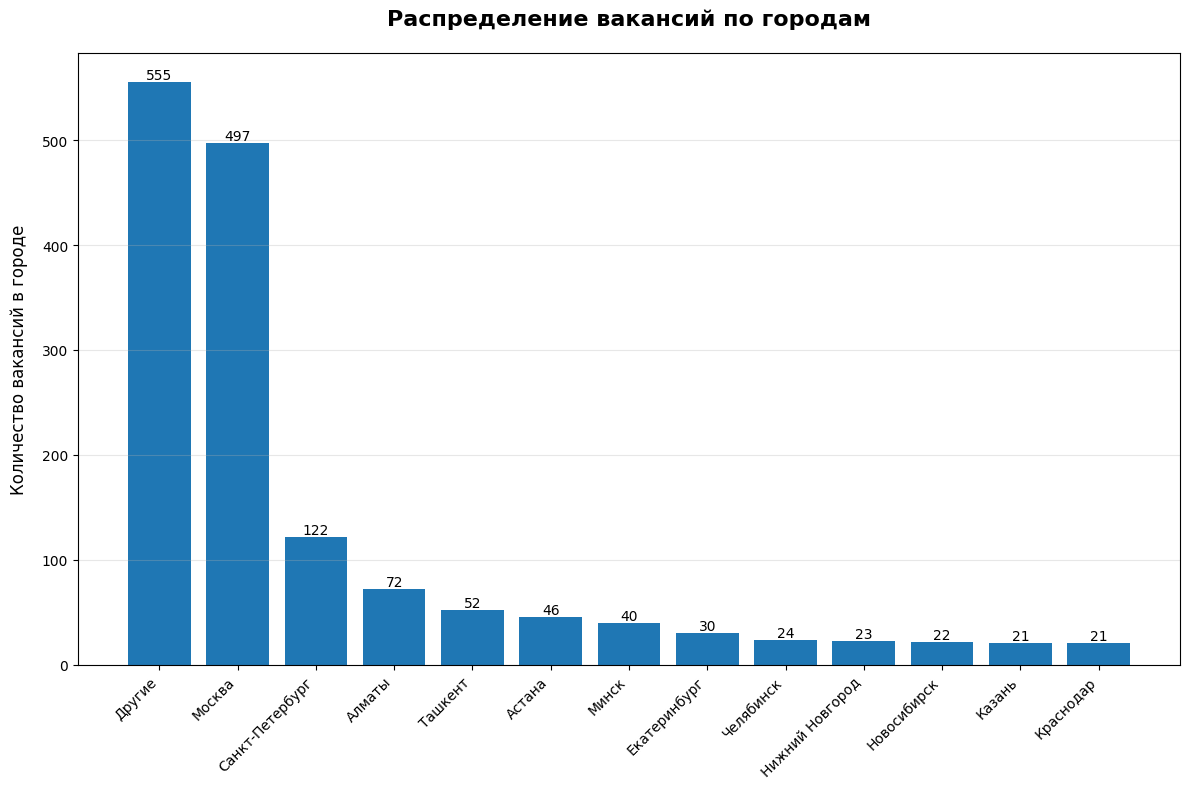

In [14]:
plt.figure(figsize=(12, 8))

bars = plt.bar(vacancy_cities.index, vacancy_cities.values)

plt.title('Распределение вакансий по городам', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Количество вакансий в городе', fontsize=12, labelpad=10)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3) 

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom')

plt.tight_layout() 

plt.show()

# Закончили
АПИ удивило скоростью работы, в целом несложно, тем более когда есть документация.